## Anomaly Detection- windowed method 

In [24]:
import numpy as np
import pickle
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [25]:
data = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [26]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[2]

In [27]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

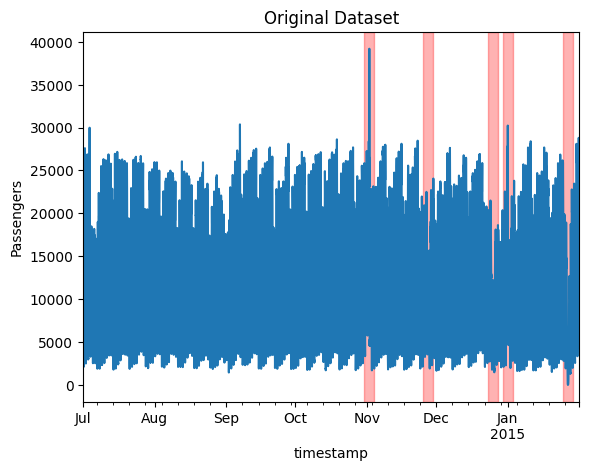

In [28]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [29]:
# Splitting to train and test
test_ratio =0.4
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
data_with_anomaly= data_with_anomaly.iloc[int(len(data) * (1 - test_ratio)) :]

In [30]:
tr_data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2014-11-06 21:30:00,26067
2014-11-06 22:00:00,25613
2014-11-06 22:30:00,23971


Normailzing the training set 

In [31]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 6192


Function to create the windowed data

Each sample is half an hour apart, so 336 samples accounts for a week

In [32]:
step_size = 336

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (5857, 336, 1)


VAE model

In [33]:
vae = vae_window(train, latent_dim=8)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 336, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 168, 32)   │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 168, 32)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 84, 16)    │      3,600 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     25,376 │ input_layer_2[0]… │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1344)      │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 336, 1)    │     66,465 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     10,760 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     10,760 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 336, 1)    │          0 │ input_layer_2[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,841 (358.75 KB)

 Trainable params: 91,841 (358.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 36437.5938 - val_loss: 16935.6270
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 13189.9004 - val_loss: 8473.2617
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6357.6401 - val_loss: 5667.0322
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4506.8643 - val_loss: 4617.8960
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3610.4302 - val_loss: 3807.3638
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3063.0229 - val_loss: 3318.8503
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2650.7830 - val_loss: 2928.4946
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2291.2354 - val_loss: 2519.8894
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2052.4436 - val_loss: 2347.5103
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1883.0891 - val_loss: 2186.7786
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1756.6738 - val_loss: 2100

In [35]:
# from sklearn.model_selection import KFold

# # Define the number of folds
# n_folds = 5

# # Create a KFold object
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# # Initialize a list to hold the history objects returned by the fit method
# histories = []

# # Loop over the indices returned by kfold.split
# for train_index, val_index in kfold.split(train):
#     # Generate the training and validation datasets
#     train_fold = train[train_index]
#     val_fold = train[val_index]

#     # Fit the model and append the history object to the list
#     history = vae.fit(
#         train_fold,
#         train_fold,
#         epochs=50,
#         batch_size=128,
#         validation_data=(val_fold, val_fold),
#         callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
#     )
#     histories.append(history)

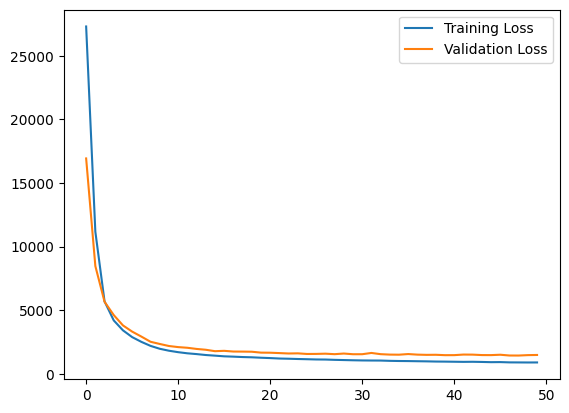

In [36]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [37]:
# plt.figure(figsize=(10, 6))

# # Loop over the history objects
# for i, history in enumerate(histories):
#     # Plot the training loss
#     plt.plot(history.history['loss'], label='train loss fold {}'.format(i+1))
#     # Plot the validation loss
#     plt.plot(history.history['val_loss'], label='val loss fold {}'.format(i+1))

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(5857, 1)


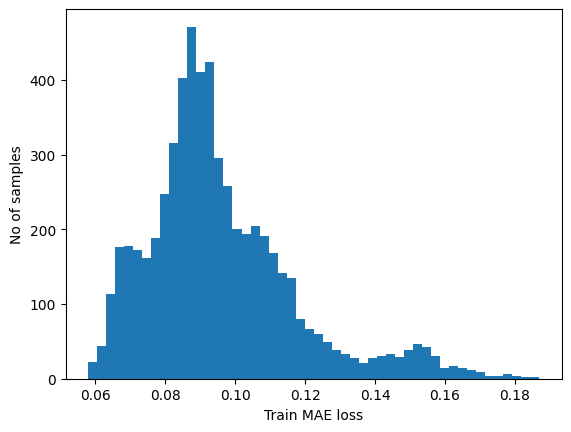

Reconstruction error threshold:  0.18692463694591316


In [38]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [39]:
print(train_pred.shape)

(5857, 336, 1)


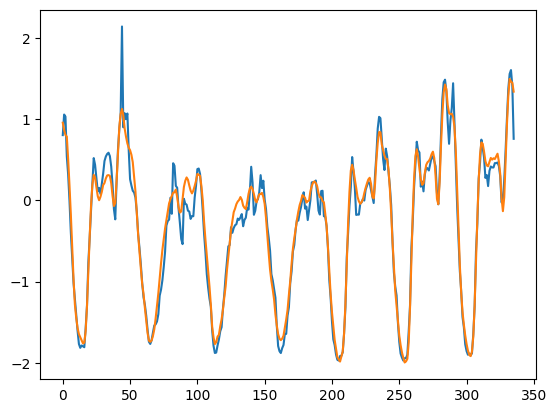

In [40]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

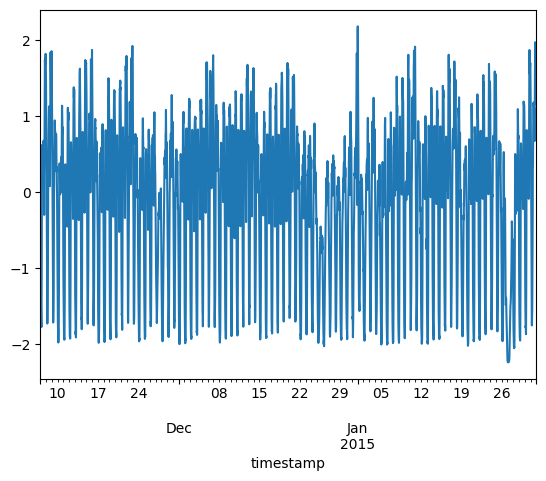

Test input shape:  (3793, 336, 1)
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(3793, 1)


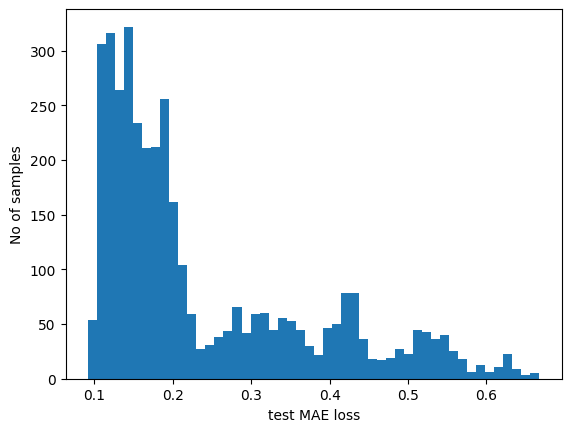

Number of anomaly samples:  1810
Indices of anomaly samples:  (array([ 632,  633,  634, ..., 3790, 3791, 3792], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [41]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [42]:
anomalous_data_indices = []
for ind in range(len(anomalies)):
    if anomalies[ind]:
        anomalous_data_indices.append(ind)

In [43]:
# # data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
# anomalous_data_indices = []
# for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
#     if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
#         anomalous_data_indices.append(data_idx)

In [44]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 8

In [45]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-11-20 04:00:00,2591
2014-11-20 04:30:00,2253
2014-11-20 05:00:00,2489
2014-11-20 05:30:00,4419
2014-11-20 06:00:00,7014
...,...
2015-01-24 22:00:00,24357
2015-01-24 22:30:00,25009
2015-01-24 23:00:00,25641


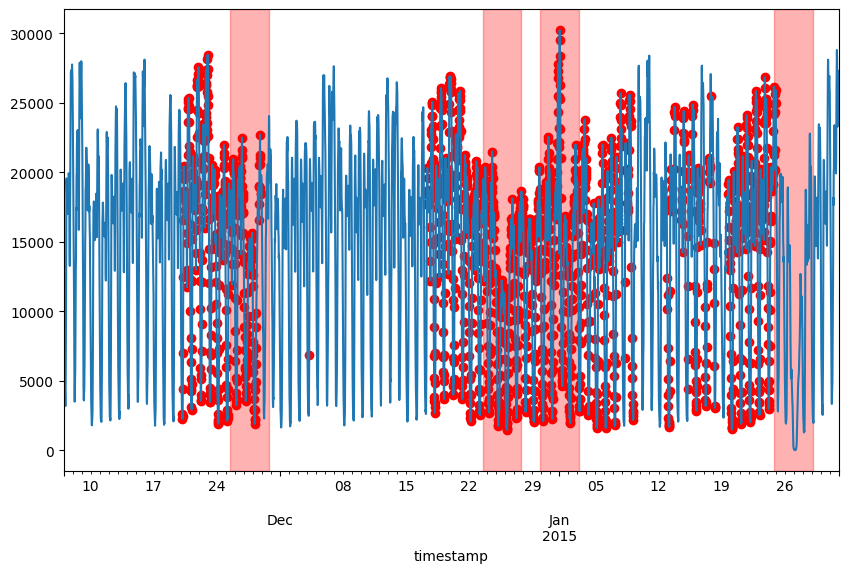

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()